In [1]:

import matplotlib
from matplotlib import pyplot as plt
import numpy as np # library which more efficiently allows you to work with large multidimensional arrays and matrices.  It has functions that operate on the arrays/matrices
import pandas as pd # built on numpy.  Makes it easier to read in data and clean data among other things

import sklearn

from sklearn import linear_model
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler,LabelEncoder,OneHotEncoder # Scaling is suggested when running a gradient descent algorithm
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
import numpy.random as r

from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score,r2_score,mean_squared_error,accuracy_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, Flatten, Dense

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten

from sklearn.preprocessing import PolynomialFeatures, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

from sklearn.svm import SVC

%matplotlib inline

Preprocessing the data!

In [2]:
file_path = "rf_signal_data.csv"
rf_data = pd.read_csv(file_path)

#check how the data looks
#print(rf_data)

#Let's hot encode the modulation types, weather conditions, interference type, Antenna Type, and device status using integers
label_encoder = LabelEncoder()
rf_data['Modulation_Original'] = rf_data['Modulation']
rf_data['Modulation'] = label_encoder.fit_transform(rf_data['Modulation']) + 1  # Add 1 to avoid 0 indexing
rf_data['Interference Type'] = label_encoder.fit_transform(rf_data['Interference Type']) + 1
rf_data['Weather Condition'] = label_encoder.fit_transform(rf_data['Weather Condition']) + 1
rf_data['Device Status'] = label_encoder.fit_transform(rf_data['Device Status']) + 1
rf_data['Antenna Type'] = label_encoder.fit_transform(rf_data['Antenna Type']) + 1
print(rf_data)

X = rf_data.loc[:,~rf_data.columns.isin(['Modulation','Timestamp','Location','Device Type','Latitude','Longitude','Altitude','Air Pressure','I/Q Data','Modulation_Original','Weather Condition','Antenna Type' ])]
y = rf_data['Modulation']

#Split the data into test data and validation data
X_train, X_test, y_train, y_test = train_test_split( X, y,random_state=42)

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(X)

#print(X_train)

                  Timestamp  Frequency  Signal Strength  Modulation  \
0       2023-05-05 00:00:00  120000000              -44           5   
1       2023-05-05 00:00:20  160000000              -97           4   
2       2023-05-05 00:00:40   90000000              -87           3   
3       2023-05-05 00:01:00  160000000              -29           4   
4       2023-05-05 00:01:20   70000000              -26           1   
...                     ...        ...              ...         ...   
164155  2023-06-11 23:58:20  160000000              -63           3   
164156  2023-06-11 23:58:40  120000000              -15           5   
164157  2023-06-11 23:59:00  160000000              -97           4   
164158  2023-06-11 23:59:20  120000000              -29           2   
164159  2023-06-11 23:59:40   70000000              -68           5   

        Bandwidth      Location Device Type  Antenna Type  Temperature  \
0           50000  Patna, Bihar      HackRF             4           24   

# Supervised Analysis I: Logistic Regression

Process the data so that we can perform logistic regression:

In [8]:
ones = np.ones((X_train.shape[0],1))
ones2 = np.ones((X_test.shape[0],1))
X_train_logistic = np.hstack((ones,X_train))
X_test_logistic = np.hstack((ones2,X_test))

y_2d_train = np.array(y_train).reshape(-1, 1)
y_2d_test = np.array(y_test).reshape(-1, 1)

enc = OneHotEncoder(handle_unknown = 'ignore')
enc.fit(y_2d_train)
y_2d_train_log = enc.transform(y_2d_train).toarray()
print(y_2d_train_log.shape)

enc.fit(y_2d_test)
y_2d_test_log = enc.transform(y_2d_test).toarray()
print(y_2d_test_log.shape)

(123120, 6)
(41040, 6)


Define the necessary functions:

In [9]:
#sigmoid function
def sigmoid(z):
  return 1/(1+np.exp(-z))
# print(sigmoid(0))

w_init = np.random.randn(X_train_logistic.shape[1],1)

#print(w_init)

#hypothesis function
def hypothesis(X, w):
    return sigmoid(X.dot(w)) #check over if models not working

# y_hat_init = hypothesis(X_train_logistic,w_init)

def log_likelihood(X, y, w):
    z = hypothesis(X,w)
    result = ((y*(np.log(z))) + (1-y)*np.log(1-z)).sum()

    return result # you should return a real number, not a list containing a real number

# Write the gradient ascent function
def Gradient_Ascent(X, y, learning_rate, num_iters):
    # We assume X has been augmented with a column of ones

    # Number of training examples.
    N = X.shape[0]

    # Initialize w(<np.ndarray>). Zeros vector of shape X.shape[1],1
    w = np.zeros((X.shape[1],y.shape[1]))

    # Initiating list to store values of likelihood(<list>) after few iterations.
    log_likelihood_values = []

    # Gradient Ascent - local optimization technique
    for i in range(num_iters):
        w += (learning_rate/N)*((X.T).dot(y-hypothesis(X,w)))
        # Computing log likelihood of seeing examples for current value of w
        if (i % 10) == 0:
            log_likelihood_values.append(log_likelihood(X, y, w))
            #print(log_likelihood(X, y, w))

    return w, log_likelihood_values



Let's try different learning rates and iteration values:

In [10]:
# Please try many different values for the learning rate (including very small values).
learning_rate = 0.01
num_iters = 500
# Calculate w and likelihood values using Gradient_Ascent with X_train_1, y_2d_train
w, log_likelihood_values = Gradient_Ascent(X_train_logistic, y_2d_train, learning_rate, num_iters)
# print(log_likelihood_values)

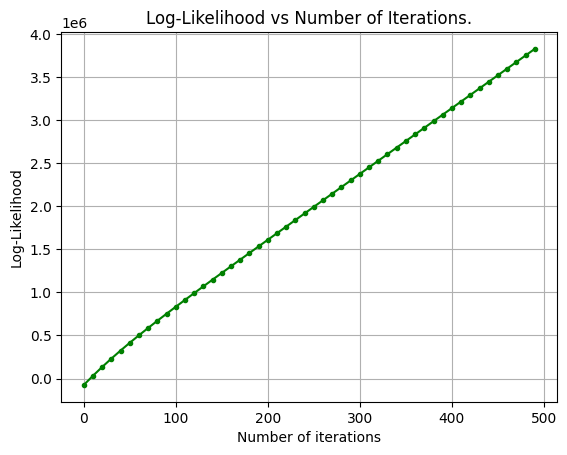

In [11]:
iters = np.array(range(0,num_iters,10))
# iters = np.array(range(num_iters))
plt.plot(iters,log_likelihood_values,'.-',color='green')
plt.xlabel('Number of iterations')
plt.ylabel('Log-Likelihood')
plt.title("Log-Likelihood vs Number of Iterations.")
plt.grid()
plt.show(block=False)


Let's predict Modulation Classes using Soft-max logistic regression

(41040, 6) (41040, 6) (123120, 6)


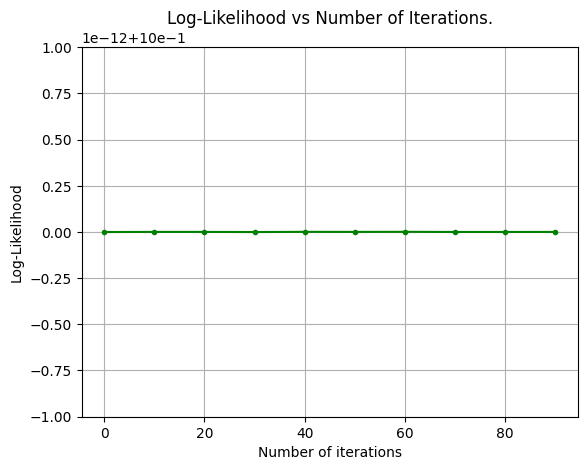

[[4.06483763e-06 4.07215720e-06 4.08205626e-06 4.06467590e-06
  4.04437017e-06 4.03833676e-06]
 [4.04442768e-06 4.05326212e-06 4.05873604e-06 4.04740117e-06
  4.07430449e-06 4.08830953e-06]
 [4.10506417e-06 4.08779078e-06 4.03879395e-06 4.06239009e-06
  4.05758734e-06 4.01528400e-06]
 ...
 [4.07586254e-06 4.05823689e-06 4.02102604e-06 4.05281008e-06
  4.09480287e-06 4.06390003e-06]
 [4.06551575e-06 4.07317775e-06 4.05889073e-06 4.07196400e-06
  4.04670667e-06 4.05008418e-06]
 [4.09486703e-06 4.07564063e-06 4.03439138e-06 4.05268773e-06
  4.06676356e-06 4.04222327e-06]]


In [12]:
#check one hot encoding
# print(y_2d_train_log)

#reshape w_init for softmax
# w_init = np.random.randn(X_train_logistic.shape[1],y_2d_test_log.shape[1])
w_init = np.zeros((X_train_logistic.shape[1],y_2d_test_log.shape[1]))


# print(w_init)
# print(w_init.shape)

#define softmax function
def softmax(X,w):
    e_x = np.exp(X.dot(w))
    return e_x / e_x.sum()

#define log_likelihood
def log_likelihood(X, y, w):
    p_scores = softmax(X,w)
    result = (y.T.dot(np.log(p_scores))).sum()

    return result

#define new Gradient Ascent Function
def Gradient_Ascent(X, y, learning_rate, num_iters):
    # We assume X has been augmented with a column of ones

    # Number of training examples.
    N = X.shape[0]

    # Initialize w(<np.ndarray>). Zeros vector of shape X.shape[1],1
    w = np.zeros((X.shape[1],y.shape[1]))

    # Initiating list to store values of likelihood(<list>) after few iterations.
    log_likelihood_values = []

    # Gradient Ascent - local optimization technique
    for i in range(num_iters):
        w += (learning_rate/N)*((X.T).dot(y-softmax(X,w)))
        # Computing log likelihood of seeing examples for current value of w
        if (i % 10) == 0:
            log_likelihood_values.append(softmax(X,w).sum())
            #print(log_likelihood(X, y, w))

    return w, log_likelihood_values

# print(log_likelihood(X_train_logistic,y_2d_train_log,w_init))

# Please try many different values for the learning rate (including very small values).
learning_rate = .01
num_iters = 100
# Calculate w and likelihood values using Gradient_Ascent with X_train_1, y_2d_train
w, log_likelihood_values = Gradient_Ascent(X_train_logistic, y_2d_train_log, learning_rate, num_iters)
# print(w, log_likelihood_values)
y_result_test = softmax(X_test_logistic,w)

# correct = 0
# for i in range(y_result_test.shape[0]):
#   if np.argmax(y_result_test[i, :]) == np.argmax(y_2d_test[i, :]):
#     correct += 1
# accuracy = correct / y_result_test.shape[0]
# print(accuracy)


# print(y_2d_test.shape, y_result_test.shape)
# for i in range(y_result_test.shape[0]):
#   y_result_test[i, :] = np.argmax(y_result_test[i, :])
#   y_2d_test[i, :] = np.argmax(y_2d_test[i, :])
# print(y_2d_test.shape, y_result_test.shape)



print(y_2d_test_log.shape, y_result_test.shape, y_2d_train_log.shape)


correct = 0
for i in range(y_result_test.shape[0]):
  if np.argmax(y_result_test[i, :]) == np.argmax(y_2d_test_log[i, :]):
    correct += 1
accuracy = correct / y_result_test.shape[0]
# print(accuracy)

# accuracy = accuracy_score(y_2d_test_log, y_result_test)

iters = np.array(range(0,num_iters,10))
plt.plot(iters,log_likelihood_values,'.-',color='green')
plt.xlabel('Number of iterations')
plt.ylabel('Log-Likelihood')
plt.title("Log-Likelihood vs Number of Iterations.")
plt.grid()
plt.show(block=False)

print(y_result_test)

In [3]:
logreg = linear_model.LogisticRegression(penalty=None)
logreg.fit(X_train, y_train)
w_logreg = logreg.coef_
intercept_logreg = w_logreg[0,0]
# Find the predicted values on test set (X_test not X_test_1) using logreg.predict
y_hat_logreg = logreg.predict(X_test)

# Find the accuracy achieved on test set using logreg.score and y_test
acc_logreg = logreg.score(X_train, y_train)

print("Accuracy on training data = %f" % acc_logreg)

Accuracy on training data = 0.172247


In [4]:

# Different lambda values to test
#this is a list of lambda values from 0 to 10 with precision of 2 decimal places
λ = [10**i for i in range(-3,4)]
print("λ:",λ)

#print(λ)

#instance of LogisticRegressionCV with ridge regularization (l2) and 5-fold cross-validation
logreg_cv = LogisticRegressionCV(Cs = λ, cv = 5, penalty='l2', scoring='accuracy')
#apply to X and Y training data
logreg_cv.fit(X_train, y_train)


# Print out the optimal value of λ using .C_ method
print("Optimal λ:", logreg_cv.C_[0])

#logistic regresion error without regularization
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
acc_train_no_reg = accuracy_score(y_train, logreg.predict(X_train))
acc_test_no_reg = accuracy_score(y_test, logreg.predict(X_test))

#non regularized
print("Non-Regularized Accuracy on training data:", acc_train_no_reg)
print("Non-Regularized Accuracy on validation data:", acc_test_no_reg)

#regularized
print("Regularized Accuracy on training data:", logreg_cv.score(X_train, y_train))
print("Regularized Accuracy on test data:", logreg_cv.score(X_test, y_test))

r2 = r2_score(y_test,logreg.predict(X_test))


λ: [0.001, 0.01, 0.1, 1, 10, 100, 1000]
Optimal λ: 0.01
Non-Regularized Accuracy on training data: 0.17223846653671215
Non-Regularized Accuracy on validation data: 0.16615497076023392
Regularized Accuracy on training data: 0.1722303443794672
Regularized Accuracy on test data: 0.16598440545808968


In [12]:
poly = PolynomialFeatures(degree=4)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

logreg.fit(X_train_poly, y_train)
w_logreg = logreg.coef_
intercept_logreg = w_logreg[0,0]
# Find the predicted values on test set (X_test not X_test_1) using logreg.predict
y_hat_logreg = logreg.predict(X_test_poly)

# Find the accuracy achieved on test set using logreg.score and y_test
acc_logreg = logreg.score(X_train_poly, y_train)
acc_logreg_test = logreg.score(X_test_poly,y_test)

print("Accuracy on training data = %f" % acc_logreg)
print("Accuracy on validation data = %f" % acc_logreg_test)

C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy on training data = 0.239799
Accuracy on validation data = 0.166618


# Supervised Analysis II: Support Vector Machine


Let's load the data again to make it easier to work with for SVM's


In [6]:
file_path = "rf_signal_data.csv"
rf_data = pd.read_csv(file_path)

#check how the data looks
#print(rf_data)

#Let's hot encode the modulation types, weather conditions, interference type, Antenna Type, and device status using integers
label_encoder = LabelEncoder()
rf_data['Interference Type'] = label_encoder.fit_transform(rf_data['Interference Type']) + 1
rf_data['Weather Condition'] = label_encoder.fit_transform(rf_data['Weather Condition']) + 1
rf_data['Device Status'] = label_encoder.fit_transform(rf_data['Device Status']) + 1
rf_data['Antenna Type'] = label_encoder.fit_transform(rf_data['Antenna Type']) + 1
print(rf_data)

X = rf_data.loc[:,~rf_data.columns.isin(['Modulation','Timestamp','Location','Device Type','Latitude','Longitude','Altitude','Air Pressure','I/Q Data','Modulation_Original'])]
y = rf_data['Modulation']

#Split the data into test data and validation data
X_train, X_test, y_train, y_test = train_test_split( X, y,random_state=42)

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#print(X_train)

                  Timestamp  Frequency  Signal Strength Modulation  Bandwidth  \
0       2023-05-05 00:00:00  120000000              -44        QAM      50000   
1       2023-05-05 00:00:20  160000000              -97         FM    1000000   
2       2023-05-05 00:00:40   90000000              -87       BPSK     500000   
3       2023-05-05 00:01:00  160000000              -29         FM     100000   
4       2023-05-05 00:01:20   70000000              -26       8PSK      10000   
...                     ...        ...              ...        ...        ...   
164155  2023-06-11 23:58:20  160000000              -63       BPSK     200000   
164156  2023-06-11 23:58:40  120000000              -15        QAM      10000   
164157  2023-06-11 23:59:00  160000000              -97         FM      10000   
164158  2023-06-11 23:59:20  120000000              -29         AM     500000   
164159  2023-06-11 23:59:40   70000000              -68        QAM     100000   

            Location Device

Define all the functions necessary for SVM's

In [5]:
print(X_train)

print(y_train)

def one_vs_rest_encoding(y, modul = '8PSK'):
    y_encoded = np.where(y==modul,1,-1)
    return  y_encoded

def score(X, w):
    # To do
    return X.dot(w)

def svm_objective(w, X, y, lambda1=.1):
    # To do. This part may require several lines of code.
    # Store your answer in result.
    w0 = 0
    max_sum = np.sum(np.maximum(0,1 - y*(X.dot(w) + w0)))
    print(max_sum)
    result = (lambda1/2)*np.sum(w**2) + max_sum
    return result

#Pegasos' Algorithm
def pegasos(X_train, y_train, lambda1=0.08, num_iters=100):
    # Hyperparameters: threshold, lambda1

    # parameters
    N = X_train.shape[0]
    d = X_train.shape[1]

    t = 0
    # Initial weight vector
    w = np.ones((d,))

    for iter in range(num_iters):

        #print('Iteration %d. J: %.6f' % (iter, svm_objective(w, X_train, y_train)))

        for i in range(N):
            t = t + 1
            alpha = 1 / (lambda1 * t)
            # Complete the following code to find w. This will require several lines of code.
            if ((y_train[i] * w.T.dot(X_train[i])) >= 1):
                w = w - (alpha * lambda1 * w)
            else:
                w = w - alpha * (lambda1 * w - y_train[i] * X_train[i])

    return w

y_train_0_vs_rest = one_vs_rest_encoding(y_train, '8PSK')
print(y_train_0_vs_rest)
y_test_0_vs_rest = one_vs_rest_encoding(y_test, '8PSK')
print(y_test_0_vs_rest)







[[-4.41166997e-01  1.57371645e+00  5.48172197e-01 ...  1.72882116e-01
  -2.84217094e-14 -1.22424934e+00]
 [ 8.76698385e-01  1.64219319e+00  1.98792039e+00 ...  4.10094568e-01
  -2.84217094e-14  1.22763482e+00]
 [-7.70633342e-01 -2.06678848e-01 -7.47601178e-01 ... -9.35238910e-01
  -2.84217094e-14  1.22763482e+00]
 ...
 [-4.41166997e-01  1.40252459e+00 -7.47601178e-01 ... -1.24700385e+00
  -2.84217094e-14 -1.22424934e+00]
 [ 2.17765694e-01 -8.22969528e-01 -3.15676719e-01 ...  1.72882116e-01
  -2.84217094e-14  1.22763482e+00]
 [-1.42956603e+00  1.33404785e+00 -8.62781033e-01 ... -3.76095273e-01
  -2.84217094e-14  1.22763482e+00]]
152142    QPSK
75633     BPSK
135918    8PSK
124764     QAM
153192    BPSK
          ... 
119879    8PSK
103694      FM
131932    BPSK
146867    8PSK
121958    QPSK
Name: Modulation, Length: 123120, dtype: object
[-1 -1  1 ... -1  1 -1]
[-1  1 -1 ...  1 -1 -1]


Training the SVM

In [15]:


lambda1 = 0.01  # Regularization parameter
num_iters = 10   # Number of iterations

# A) Create the 10 classifiers
labels = ['8PSK','AM','BPSK','FM','QAM','QPSK']
w_vals= {}
val_scores = {}



for i in range(len(labels)):
    # Perform one-vs-rest for labels[i]
    # To do: Relabel the y labels in the train set to either 1 or -1 using one_vs_rest_encoding
    y_encoded = one_vs_rest_encoding(y_train,labels[i])
    #print(y_encoded)
    # To do: Train the Pegasos algorithm on X_train X_train and  y_encoded to get the weight vector
    w_vals[i] = pegasos(X_train, y_encoded,lambda1,num_iters)


    # Using the validation set, estimate accuracy for one-vs-rest classifier for labels[i]
    # To do:  Relabel the y labels in the validation set to either 1 or -1 using one_vs_rest_encoding
    y_encoded_val = one_vs_rest_encoding(y_test,labels[i])

    # This section may require more than one line of code.
    # To do: Calculate an accuracy for one-vs-rest classifier for labels[i]
    predict = np.sign(X_test.dot(w_vals[i]))
    correct_predicts = (predict == y_encoded_val)
    num_correct = np.sum(correct_predicts)

    total_samples = y_test.shape[0]
    accuracy = num_correct / total_samples

    val_scores[i] = accuracy

In [16]:
print(y_train)

for i in range(1, len(labels) + 1):
    print(labels[i-1], ": score:", val_scores[i - 1])

152142    QPSK
75633     BPSK
135918    8PSK
124764     QAM
153192    BPSK
          ... 
119879    8PSK
103694      FM
131932    BPSK
146867    8PSK
121958    QPSK
Name: Modulation, Length: 123120, dtype: object
8PSK : score: 0.4979288499025341
AM : score: 0.49987816764132553
BPSK : score: 0.5078947368421053
FM : score: 0.5011939571150097
QAM : score: 0.5013888888888889
QPSK : score: 0.5020955165692008


Let's make an array of predictions

In [17]:
# Making predictions
predictions = []
for sample in X_test:
    modul_scores = []
    for i in range(len(labels)):
        modul_score = score(sample, w_vals[i])
        modul_scores.append(modul_score)
    predicted_modulation = np.argmax(modul_scores)
    predictions.append(labels[predicted_modulation])

print("Predictions:", predictions)

Predictions: ['BPSK', 'QAM', '8PSK', 'FM', 'BPSK', 'AM', 'FM', 'QPSK', 'BPSK', 'FM', 'FM', 'QAM', 'AM', 'AM', 'QPSK', 'FM', 'QAM', 'AM', 'BPSK', 'AM', 'BPSK', 'FM', 'QPSK', 'QPSK', 'BPSK', 'FM', 'FM', 'QAM', '8PSK', 'BPSK', 'FM', 'AM', 'QPSK', 'AM', 'FM', 'QAM', 'FM', 'QPSK', 'FM', 'BPSK', 'BPSK', 'FM', 'BPSK', 'FM', 'QAM', 'QPSK', 'QAM', '8PSK', 'AM', 'BPSK', 'QAM', 'BPSK', 'AM', 'QPSK', '8PSK', 'FM', 'BPSK', 'BPSK', 'FM', '8PSK', 'FM', '8PSK', '8PSK', 'FM', 'BPSK', 'QPSK', '8PSK', 'FM', '8PSK', 'AM', 'QPSK', 'QAM', 'QPSK', '8PSK', '8PSK', '8PSK', 'AM', 'AM', 'QPSK', 'AM', 'QAM', 'QPSK', '8PSK', 'QAM', 'FM', 'FM', 'AM', 'AM', 'BPSK', 'AM', 'QPSK', '8PSK', 'QPSK', 'QPSK', 'AM', 'FM', 'QAM', 'AM', 'AM', 'QAM', 'QPSK', 'QAM', 'BPSK', 'QPSK', 'QPSK', 'AM', 'QAM', 'QAM', '8PSK', '8PSK', 'BPSK', 'BPSK', 'QAM', 'QAM', '8PSK', 'QPSK', 'FM', 'FM', 'QAM', 'QPSK', 'QPSK', 'QPSK', 'QPSK', 'BPSK', 'QPSK', 'QPSK', 'QPSK', 'QAM', 'BPSK', '8PSK', 'QPSK', 'AM', 'FM', '8PSK', 'QPSK', 'QPSK', 'QPSK', 'A

Let's check accuracy

In [18]:
y_test_list = y_test.to_list()
eval1 = np.zeros(y_test.shape[0])
print(predictions)
print(y_test_list)

# Loop through each prediction and compare with the actual label
for i in range(len(predictions)):
    #print(predictions[i],y_val[i])
    if predictions[i] == y_test_list[i]:
        eval1[i] = 1  # Correct prediction
    else:
        eval1[i] = 0  # Incorrect prediction

# Calculate the accuracy on the validation set
accuracy = np.mean(eval1)
print("Accuracy Score:", accuracy)


['BPSK', 'QAM', '8PSK', 'FM', 'BPSK', 'AM', 'FM', 'QPSK', 'BPSK', 'FM', 'FM', 'QAM', 'AM', 'AM', 'QPSK', 'FM', 'QAM', 'AM', 'BPSK', 'AM', 'BPSK', 'FM', 'QPSK', 'QPSK', 'BPSK', 'FM', 'FM', 'QAM', '8PSK', 'BPSK', 'FM', 'AM', 'QPSK', 'AM', 'FM', 'QAM', 'FM', 'QPSK', 'FM', 'BPSK', 'BPSK', 'FM', 'BPSK', 'FM', 'QAM', 'QPSK', 'QAM', '8PSK', 'AM', 'BPSK', 'QAM', 'BPSK', 'AM', 'QPSK', '8PSK', 'FM', 'BPSK', 'BPSK', 'FM', '8PSK', 'FM', '8PSK', '8PSK', 'FM', 'BPSK', 'QPSK', '8PSK', 'FM', '8PSK', 'AM', 'QPSK', 'QAM', 'QPSK', '8PSK', '8PSK', '8PSK', 'AM', 'AM', 'QPSK', 'AM', 'QAM', 'QPSK', '8PSK', 'QAM', 'FM', 'FM', 'AM', 'AM', 'BPSK', 'AM', 'QPSK', '8PSK', 'QPSK', 'QPSK', 'AM', 'FM', 'QAM', 'AM', 'AM', 'QAM', 'QPSK', 'QAM', 'BPSK', 'QPSK', 'QPSK', 'AM', 'QAM', 'QAM', '8PSK', '8PSK', 'BPSK', 'BPSK', 'QAM', 'QAM', '8PSK', 'QPSK', 'FM', 'FM', 'QAM', 'QPSK', 'QPSK', 'QPSK', 'QPSK', 'BPSK', 'QPSK', 'QPSK', 'QPSK', 'QAM', 'BPSK', '8PSK', 'QPSK', 'AM', 'FM', '8PSK', 'QPSK', 'QPSK', 'QPSK', 'AM', 'QAM', 'A

Let's try using scikit learn's built-in libraries for multi-class classification using SVM's 

In [7]:

# Create a Support Vector Machine classifier
svm_classifier = SVC(kernel='rbf', gamma = 10, C=10)

# Train the classifier on the training data
svm_classifier.fit(X_train, y_train)

# Predict the labels of the test set
y_pred = svm_classifier.predict(X_test)

# Calculate the accuracy of the classifier
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.16617933723196882


# Supervised Analysis III: Neural Network

Reload the data

In [2]:
file_path = "rf_signal_data.csv"
rf_data = pd.read_csv(file_path)

#check how the data looks
#print(rf_data)

#Let's hot encode the modulation types, weather conditions, interference type, Antenna Type, and device status using integers
label_encoder = LabelEncoder()
rf_data['Interference Type'] = label_encoder.fit_transform(rf_data['Interference Type']) + 1
rf_data['Weather Condition'] = label_encoder.fit_transform(rf_data['Weather Condition']) + 1
rf_data['Device Status'] = label_encoder.fit_transform(rf_data['Device Status']) + 1
rf_data['Antenna Type'] = label_encoder.fit_transform(rf_data['Antenna Type']) + 1
print(rf_data)

X = rf_data.loc[:,~rf_data.columns.isin(['Modulation','Timestamp','Location','Device Type','Latitude','Longitude','Altitude','Air Pressure','I/Q Data','Modulation_Original'])]
y = rf_data['Modulation']

#Split the data into test data and validation data
X_train, X_test, y_train, y_test = train_test_split( X, y,random_state=42)

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#print(X_train)

                  Timestamp  Frequency  Signal Strength Modulation  Bandwidth  \
0       2023-05-05 00:00:00  120000000              -44        QAM      50000   
1       2023-05-05 00:00:20  160000000              -97         FM    1000000   
2       2023-05-05 00:00:40   90000000              -87       BPSK     500000   
3       2023-05-05 00:01:00  160000000              -29         FM     100000   
4       2023-05-05 00:01:20   70000000              -26       8PSK      10000   
...                     ...        ...              ...        ...        ...   
164155  2023-06-11 23:58:20  160000000              -63       BPSK     200000   
164156  2023-06-11 23:58:40  120000000              -15        QAM      10000   
164157  2023-06-11 23:59:00  160000000              -97         FM      10000   
164158  2023-06-11 23:59:20  120000000              -29         AM     500000   
164159  2023-06-11 23:59:40   70000000              -68        QAM     100000   

            Location Device

Let's try different activation functions (no regularization)

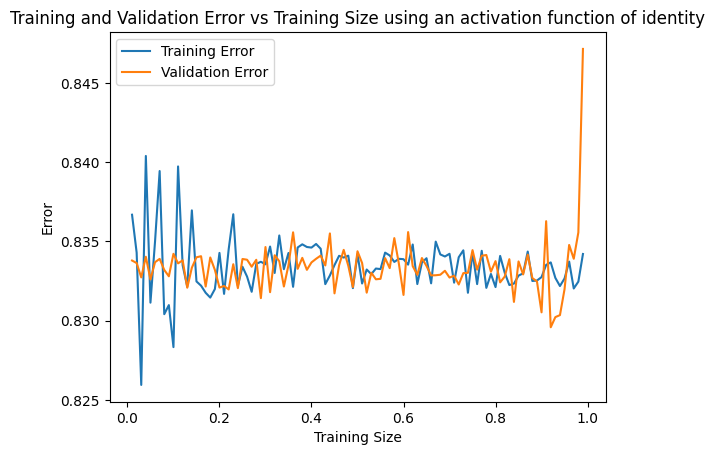

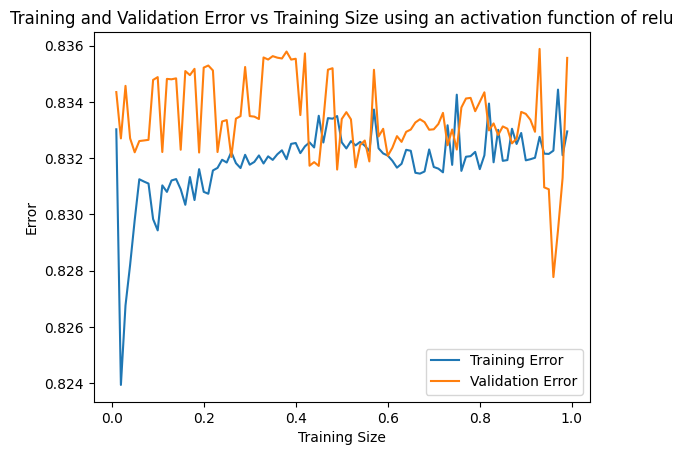

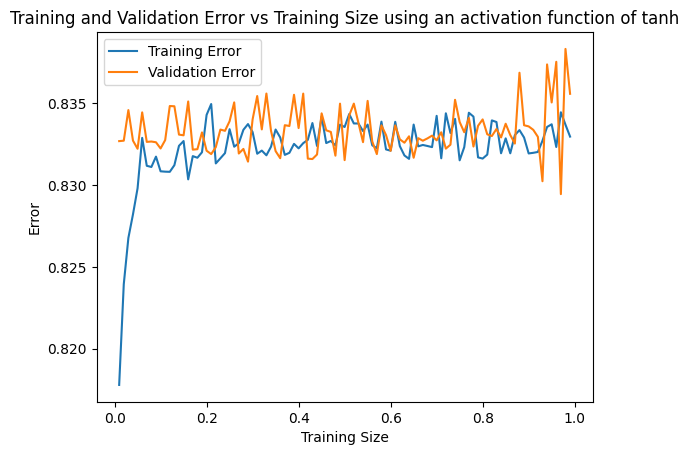

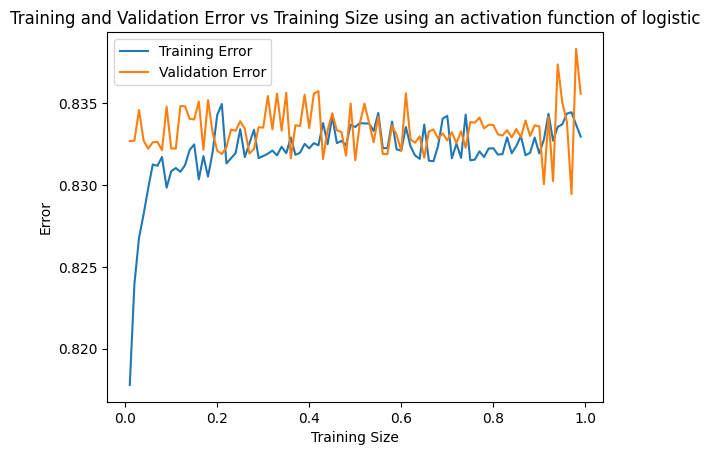

In [3]:

activation_functions = ['identity','relu','tanh','logistic']


for i in range(len(activation_functions)):
  training_split_sizes = [i * (10 ** (-2)) for i in range(1, 100)]
  train_error_arr = []
  test_error_arr = []
  for train_size in training_split_sizes:
      X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, random_state=42)
      model = MLPClassifier(hidden_layer_sizes=(6),  activation=activation_functions[i], solver='adam', random_state=1, max_iter=300)
      model.fit(X_train, y_train)

      # Make predictions
      y_pred_train = model.predict(X_train)
      y_pred_test = model.predict(X_test)

      # Calculate accuracy
      error_train = 1 - accuracy_score(y_train, y_pred_train)
      error_test = 1 -accuracy_score(y_test, y_pred_test)
    
      train_error_arr.append(error_train)
      test_error_arr.append(error_test)

      #print(f"Training Accuracy using size = {train_size:.2f}: {accuracy_train:.4f}, Validation Accuracy using size = {train_size:.2f}: {accuracy_test:.4f}")

  # Plotting the results
  plt.plot(training_split_sizes, train_error_arr, label='Training Error')
  plt.plot(training_split_sizes, test_error_arr, label='Validation Error')
  plt.xlabel('Training Size')
  plt.ylabel('Error')
  plt.title(f'Training and Validation Error vs Training Size using an activation function of {activation_functions[i]}')
  plt.legend()
  plt.show()


In [7]:
X_train, X_test, y_train, y_test = train_test_split( X, y,random_state=42)
activation_functions = ['identity','relu','tanh','logistic']

for i in range(len(activation_functions)):
  model = MLPClassifier(hidden_layer_sizes=(6),activation=activation_functions[i], solver='adam', random_state=1, max_iter=300)
  model.fit(X_train, y_train)

  # Make predictions
  y_pred_train = model.predict(X_train)
  y_pred_test = model.predict(X_test)

  # Calculate accuracy
  accuracy_train = accuracy_score(y_train,y_pred_train)
  accuracy_val = accuracy_score(y_test, y_pred_test)
  print(f"Training Accuracy using an activation function of {activation_functions[i]}:", accuracy_train,f" Validation Accuracy using an activation function of {activation_functions[i]}:",accuracy_val)

Training Accuracy using an activation function of identity: 0.1657001299545159  Validation Accuracy using an activation function of identity: 0.1655458089668616
Training Accuracy using an activation function of relu: 0.16574074074074074  Validation Accuracy using an activation function of relu: 0.16769005847953217
Training Accuracy using an activation function of tanh: 0.1684941520467836  Validation Accuracy using an activation function of tanh: 0.16615497076023392
Training Accuracy using an activation function of logistic: 0.1684941520467836  Validation Accuracy using an activation function of logistic: 0.16615497076023392


TANH produced the highest accuracies! Let's try changing the number of hidden layers now!

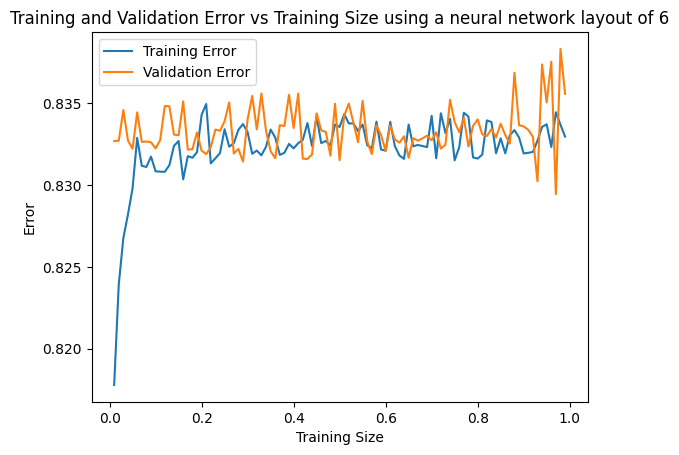

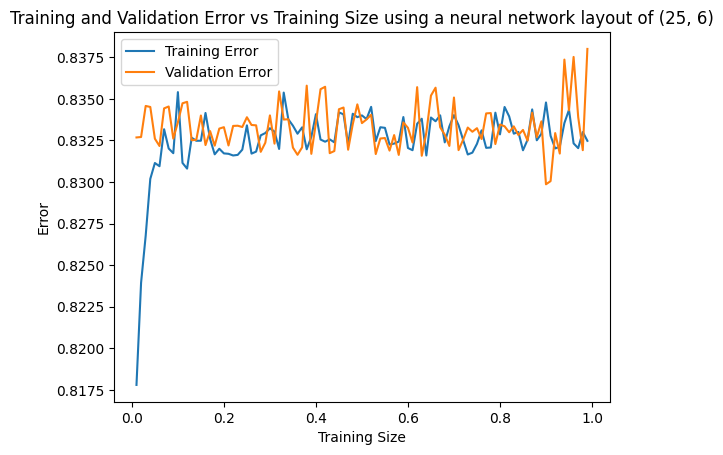

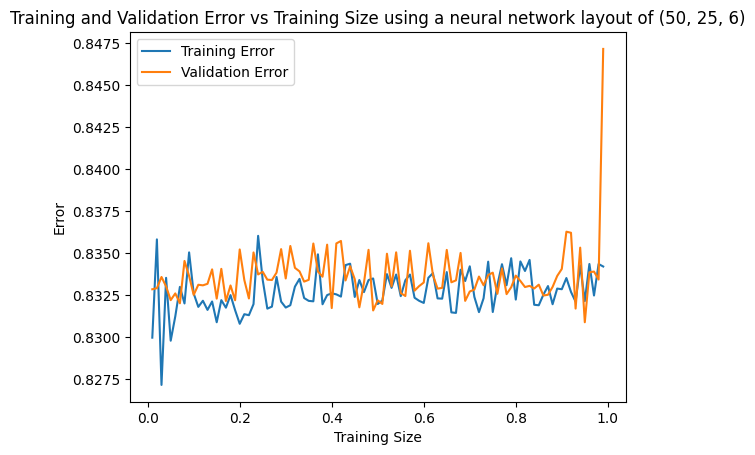

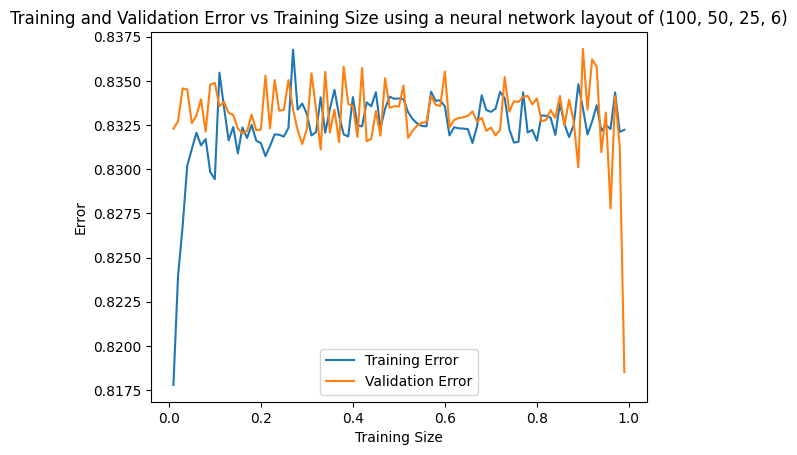

In [6]:
layouts_to_try = [(6),(25,6),(50,25,6),(100,50,25,6)]

for i in range(len(layouts_to_try)):
  training_split_sizes = [i * (10 ** (-2)) for i in range(1, 100)]
  train_error_arr = []
  test_error_arr = []
  for train_size in training_split_sizes:
      X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, random_state=42)
      model = MLPClassifier(hidden_layer_sizes=layouts_to_try[i],  activation='tanh', solver='adam', random_state=1, max_iter=300)
      model.fit(X_train, y_train)

      # Make predictions
      y_pred_train = model.predict(X_train)
      y_pred_test = model.predict(X_test)

      # Calculate accuracy
      error_train = 1 - accuracy_score(y_train, y_pred_train)
      error_test = 1 -accuracy_score(y_test, y_pred_test)
    
      train_error_arr.append(error_train)
      test_error_arr.append(error_test)

      #print(f"Training Accuracy using size = {train_size:.2f}: {accuracy_train:.4f}, Validation Accuracy using size = {train_size:.2f}: {accuracy_test:.4f}")

  # Plotting the results
  plt.plot(training_split_sizes, train_error_arr, label='Training Error')
  plt.plot(training_split_sizes, test_error_arr, label='Validation Error')
  plt.xlabel('Training Size')
  plt.ylabel('Error')
  plt.title(f'Training and Validation Error vs Training Size using a neural network layout of {layouts_to_try[i]}')
  plt.legend()
  plt.show()

In [21]:
layouts_to_try = [(6),(25,6),(50,25,6),(100,50,25,6)]
for i in range(len(layouts_to_try)):
  model = MLPClassifier(hidden_layer_sizes=layouts_to_try[i],activation='tanh', solver='adam', random_state=1, max_iter=300)
  model.fit(X_train, y_train)

  # Make predictions
  y_pred_train = model.predict(X_train)
  y_pred_test = model.predict(X_test)

  # Calculate accuracy
  accuracy_train = accuracy_score(y_train,y_pred_train)
  accuracy_val = accuracy_score(y_test, y_pred_test)
  print(f"Training Accuracy using a layout of ({layouts_to_try[i]})", accuracy_train,f" Validation Accuracy using a layout of ({layouts_to_try[i]}):",accuracy_val)

Training Accuracy using a layout of (6) 0.16704611181530662  Validation Accuracy using a layout of (6): 0.16443361753958588
Training Accuracy using a layout of ((25, 6)) 0.1675260586519647  Validation Accuracy using a layout of ((25, 6)): 0.16199756394640683
Training Accuracy using a layout of ((50, 25, 6)) 0.16579086624250852  Validation Accuracy using a layout of ((50, 25, 6)): 0.15286236297198538
Training Accuracy using a layout of ((100, 50, 25, 6)) 0.16777218523486628  Validation Accuracy using a layout of ((100, 50, 25, 6)): 0.1814859926918392


Based on the results above, increasing the number of layers causes the model to overfit as shown by the increasing difference between the training and validation accuracy as the numbers of layers increase. However, the layer layout that seemed to have the least variance was (25,6). Let's try adding regularization!

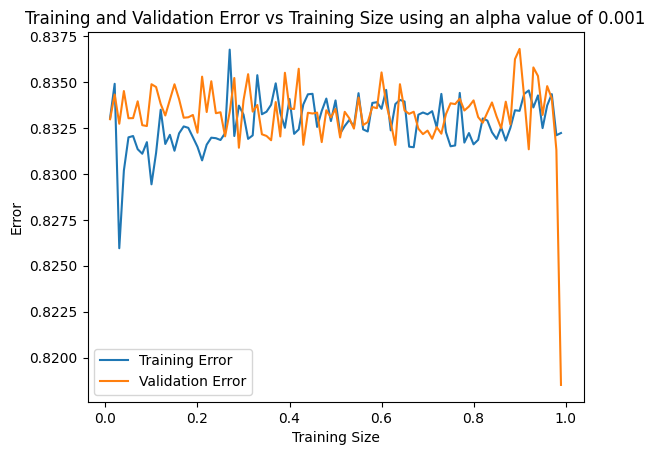

C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


In [31]:
alpha_vals = [10**i for i in range(-3,4)]


for i in range(len(alpha_vals)):
  training_split_sizes = [i * (10 ** (-2)) for i in range(1, 100)]
  train_error_arr = []
  test_error_arr = []
  for train_size in training_split_sizes:
      X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, random_state=42)
      model = MLPClassifier(hidden_layer_sizes=(100,50,25,6),  alpha = alpha_vals[i], activation='tanh', solver='adam', random_state=1, max_iter=300)
      model.fit(X_train, y_train)

      # Make predictions
      y_pred_train = model.predict(X_train)
      y_pred_test = model.predict(X_test)

      # Calculate accuracy
      error_train = 1 - accuracy_score(y_train, y_pred_train)
      error_test = 1 -accuracy_score(y_test, y_pred_test)
    
      train_error_arr.append(error_train)
      test_error_arr.append(error_test)

      #print(f"Training Accuracy using size = {train_size:.2f}: {accuracy_train:.4f}, Validation Accuracy using size = {train_size:.2f}: {accuracy_test:.4f}")

  # Plotting the results
  plt.plot(training_split_sizes, train_error_arr, label='Training Error')
  plt.plot(training_split_sizes, test_error_arr, label='Validation Error')
  plt.xlabel('Training Size')
  plt.ylabel('Error')
  plt.title(f'Training and Validation Error vs Training Size using an alpha value of {alpha_vals[i]}')
  plt.legend()
  plt.show()

In [30]:
alpha_vals = [10**i for i in range(-3,4)]

for i in range(len(alpha_vals)):
  model = MLPClassifier(hidden_layer_sizes=(100,50,25,6), alpha = alpha_vals[i],activation='tanh', solver='adam', random_state=1, max_iter=300)
  model.fit(X_train, y_train)

  # Make predictions
  y_pred_train = model.predict(X_train)
  y_pred_test = model.predict(X_test)

  # Calculate accuracy
  accuracy_train = accuracy_score(y_train,y_pred_train)
  accuracy_val = accuracy_score(y_test, y_pred_test)
  print(f"Training Accuracy using alpha = {alpha_vals[i]}:", accuracy_train,f" Validation Accuracy using alpha = {alpha_vals[i]}:",accuracy_val)

Training Accuracy using alpha = 0.001: 0.16777218523486628  Validation Accuracy using alpha = 0.001: 0.1814859926918392
Training Accuracy using alpha = 0.01: 0.16704611181530662  Validation Accuracy using alpha = 0.01: 0.16443361753958588
Training Accuracy using alpha = 0.1: 0.165557045988752  Validation Accuracy using alpha = 0.1: 0.18087697929354446
Training Accuracy using alpha = 1: 0.16630773206660185  Validation Accuracy using alpha = 1: 0.15834348355663824
Training Accuracy using alpha = 10: 0.16704611181530662  Validation Accuracy using alpha = 10: 0.16443361753958588
Training Accuracy using alpha = 100: 0.1675260586519647  Validation Accuracy using alpha = 100: 0.16199756394640683
Training Accuracy using alpha = 1000: 0.1675260586519647  Validation Accuracy using alpha = 1000: 0.16199756394640683


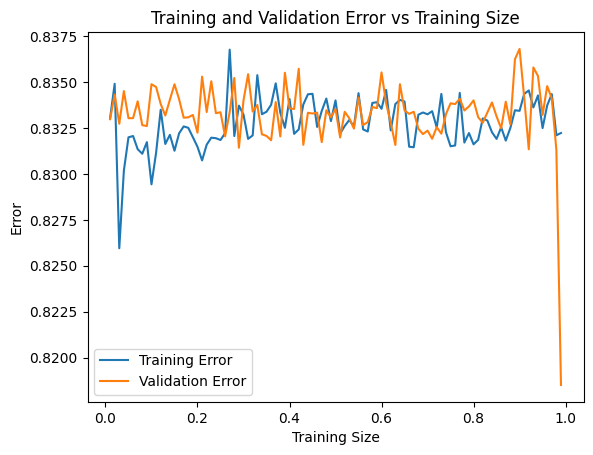

In [3]:


training_split_sizes = [i * (10 ** (-2)) for i in range(1, 100)]
train_error_arr = []
test_error_arr = []

for train_size in training_split_sizes:
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, random_state=42)
    model = MLPClassifier(hidden_layer_sizes=(100,50,25,6), alpha = 0.001,  activation='tanh', solver='adam', random_state=1, max_iter=300)
    model.fit(X_train, y_train)

    # Make predictions
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    # Calculate accuracy
    error_train = 1 - accuracy_score(y_train, y_pred_train)
    error_test = 1 -accuracy_score(y_test, y_pred_test)
  
    train_error_arr.append(error_train)
    test_error_arr.append(error_test)

    #print(f"Training Accuracy using size = {train_size:.2f}: {accuracy_train:.4f}, Validation Accuracy using size = {train_size:.2f}: {accuracy_test:.4f}")

# Plotting the results
plt.plot(training_split_sizes, train_error_arr, label='Training Error')
plt.plot(training_split_sizes, test_error_arr, label='Validation Error')
plt.xlabel('Training Size')
plt.ylabel('Error')
plt.title('Training and Validation Error vs Training Size')
plt.legend()
plt.show()


Let's try transforming the features using a polynomial transform of degree 2

In [5]:
training_split_sizes = [i * (10 ** (-2)) for i in range(1, 100)]
train_error_arr = []
test_error_arr = []

for train_size in training_split_sizes:
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, random_state=42)
    poly = PolynomialFeatures(degree=2)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.transform(X_test)
    model = MLPClassifier(hidden_layer_sizes=(100,50,25,6), alpha = 0.001,  activation='tanh', solver='adam', random_state=1, max_iter=300)
    model.fit(X_train_poly, y_train)

    # Make predictions
    y_pred_train = model.predict(X_train_poly)
    y_pred_test = model.predict(X_test_poly)

    # Calculate accuracy
    error_train = 1 - accuracy_score(y_train, y_pred_train)
    error_test = 1 -accuracy_score(y_test, y_pred_test)
  
    train_error_arr.append(error_train)
    test_error_arr.append(error_test)

    #print(f"Training Accuracy using size = {train_size:.2f}: {accuracy_train:.4f}, Validation Accuracy using size = {train_size:.2f}: {accuracy_test:.4f}")

# Plotting the results
plt.plot(training_split_sizes, train_error_arr, label='Training Error')
plt.plot(training_split_sizes, test_error_arr, label='Validation Error')
plt.xlabel('Training Size')
plt.ylabel('Error')
plt.title('Training and Validation Error vs Training Size Using Polynomial Feature Transformation of Degree 2')
plt.legend()
plt.show()


Let's try transforming the features using a dimensionality reduction transformation (PCA)

# Supervised Analysis IV: Convolutional Neural Network

In [2]:
file_path = "rf_signal_data.csv"
rf_data = pd.read_csv(file_path)

#check how the data looks
#print(rf_data)

#Let's hot encode the modulation types, weather conditions, interference type, Antenna Type, and device status using integers
label_encoder = LabelEncoder()
rf_data['Modulation'] = label_encoder.fit_transform(rf_data['Modulation']) + 1
rf_data['Interference Type'] = label_encoder.fit_transform(rf_data['Interference Type']) + 1
rf_data['Weather Condition'] = label_encoder.fit_transform(rf_data['Weather Condition']) + 1
rf_data['Device Status'] = label_encoder.fit_transform(rf_data['Device Status']) + 1
rf_data['Antenna Type'] = label_encoder.fit_transform(rf_data['Antenna Type']) + 1
print(rf_data)

X = rf_data.loc[:,~rf_data.columns.isin(['Modulation','Timestamp','Location','Device Type','Latitude','Longitude','Altitude','Air Pressure','I/Q Data','Modulation_Original'])]
y = rf_data['Modulation']

#Split the data into test data and validation data
X_train, X_test, y_train, y_test = train_test_split( X, y,random_state=42)

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#print(X_train)

                  Timestamp  Frequency  Signal Strength  Modulation  \
0       2023-05-05 00:00:00  120000000              -44           5   
1       2023-05-05 00:00:20  160000000              -97           4   
2       2023-05-05 00:00:40   90000000              -87           3   
3       2023-05-05 00:01:00  160000000              -29           4   
4       2023-05-05 00:01:20   70000000              -26           1   
...                     ...        ...              ...         ...   
164155  2023-06-11 23:58:20  160000000              -63           3   
164156  2023-06-11 23:58:40  120000000              -15           5   
164157  2023-06-11 23:59:00  160000000              -97           4   
164158  2023-06-11 23:59:20  120000000              -29           2   
164159  2023-06-11 23:59:40   70000000              -68           5   

        Bandwidth      Location Device Type  Antenna Type  Temperature  \
0           50000  Patna, Bihar      HackRF             4           24   

In [3]:

# Define the input shape based on the number of features
input_shape = X_train.shape[1:]

# Define the model
model = Sequential([
    Dense(64, activation='tanh', input_shape=input_shape),
    Dropout(0.2),
    Dense(32, activation='tanh'),
    Dropout(0.2),
    Dense(10, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3848/3848 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.1637 - loss: 1.9091 - val_accuracy: 0.1697 - val_loss: 1.7945
Epoch 2/10
3848/3848 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.1672 - loss: 1.7949 - val_accuracy: 0.1665 - val_loss: 1.7927
Epoch 3/10
3848/3848 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.1692 - loss: 1.7932 - val_accuracy: 0.1663 - val_loss: 1.7927
Epoch 4/10
3848/3848 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.1657 - loss: 1.7932 - val_accuracy: 0.1683 - val_loss: 1.7930
Epoch 5/10
3848/3848 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.1678 - loss: 1.7930 - val_accuracy: 0.1679 - val_loss: 1.7929
Epoch 6/10
3848/3848 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.1699 - loss: 1.7928 - val_accuracy: 0.1622 - val_loss: 1.7929
Epoch 7/10
3848/3848 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.1674 - loss: 1.7928 - val_accuracy: 0.1669 - val_loss: 1.7927
Epoch 8/10
3848/3848 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.1675 - loss: 1.7925 - val_accurac

In [15]:

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Define the model
model = Sequential([
    Conv1D(32, 3, activation='sigmoid', input_shape=X_train.shape[1:]),
    MaxPooling1D(2),
    Conv1D(64, 3, activation='sigmoid'),
    MaxPooling1D(2),
    Flatten(),
    Dense(64, activation='sigmoid'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
3848/3848 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.1675 - loss: 1.8534 - val_accuracy: 0.1662 - val_loss: 1.7932
Epoch 2/10
3848/3848 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.1687 - loss: 1.7941 - val_accuracy: 0.1662 - val_loss: 1.7939
Epoch 3/10
3848/3848 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.1688 - loss: 1.7931 - val_accuracy: 0.1668 - val_loss: 1.7926
Epoch 4/10
3848/3848 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.1631 - loss: 1.7926 - val_accuracy: 0.1662 - val_loss: 1.7919
Epoch 5/10
3848/3848 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.1679 - loss: 1.7921 - val_accuracy: 0.1662 - val_loss: 1.7923
Epoch 6/10
3848/3848 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.1658 - loss: 1.7920 - val_accuracy: 0.1655 - val_loss: 1.7918
Epoch 7/10
3848/3848 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.1668 - loss: 1.7919 - val_accuracy: 0.1655 - val_loss: 1.7918
Epoch 8/10
3848/3848 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.1670 - loss: 1.